# Training data analysis

The aim of this notebook is to analyze each gwa class, including counts of taks, metrics in each label. And try to find out why all the metrics during evaluation are totally same.

In [22]:
import pandas as pd
import numpy as np
import json, csv


from datasets import load_dataset, load_metric
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import balanced_accuracy_score,f1_score,recall_score,precision_score, hamming_loss


import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score

In [23]:
de_path = '/srv/scratch2/jinq/taskontology/task_to_GWA_IWA_DWA_DE.csv'
data_df = pd.read_csv(de_path, index_col=0)
data_df.head()

,O*NET-SOC Code,Title,Task ID,Task,DWA ID,DWA Title,Date,Domain Source,Task_de,GWA ID,GWA Title,IWA ID,IWA Title,GWA_de,IWA_de,DWA_de
0,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or publi...",4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,07/2014,Analyst,['Überprüfung und Analyse von Rechtsvorschrift...,4.A.2.a.4,Analyzing Data or Information,4.A.2.a.4.I09,Assess characteristics or impacts of regulatio...,['Analysieren von Daten oder Informationen'],['Beurteilung von Merkmalen oder Auswirkungen ...,['Analyse der Auswirkungen von rechtlichen ode...
1,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or publi...",4.A.4.b.6.I08.D04,Advise others on legal or regulatory complianc...,07/2014,Analyst,['Überprüfung und Analyse von Rechtsvorschrift...,4.A.4.b.6,Providing Consultation and Advice to Others,4.A.4.b.6.I08,Advise others on legal or regulatory matters.,['Beratung und Beratung der anderen'],['Sie beraten andere über rechtliche oder regu...,['Sie beraten andere über die rechtliche oder ...
2,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,4.A.4.b.4.I09.D02,Direct financial operations.,03/2014,Analyst,['Direkt oder koordiniert eine Organisation fi...,4.A.4.b.4,"Guiding, Directing, and Motivating Subordinates",4.A.4.b.4.I09,Manage budgets or finances.,"['Guiding, Directing, and motivation Subordina...",['Verwaltung von Budgets oder Finanzen.'],['Direkte Finanzoperationen.']
3,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",4.A.4.a.2.I03.D14,Confer with organizational members to accompli...,03/2014,Analyst,"['Controlling mit Vorstandsmitgliedern, Organi...",4.A.4.a.2,"Communicating with Supervisors, Peers, or Subo...",4.A.4.a.2.I03,Communicate with others about operational plan...,"['Kommunikation mit Supervisor, Peers, oder Su...",['Kommunizieren Sie mit anderen über operation...,['Begleitung von Organisationsmitgliedern zur ...
4,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,4.A.2.a.4.I07.D09,Analyze data to assess operational or project ...,03/2014,Analyst,"['Sie analysieren Operationen, um die Leistung...",4.A.2.a.4,Analyzing Data or Information,4.A.2.a.4.I07,Analyze data to improve operations.,['Analysieren von Daten oder Informationen'],['Analyse von Daten zur Verbesserung der Arbei...,"['Analysieren von Daten, um operationelle oder..."


In [24]:
# tasks in this table is not unique, the mapping relationship is
print('Unique tasks: ', data_df.Task_de.nunique() == data_df.shape[0])
print('Null values: ', data_df.isnull().values.any())
# df[df.isna().any(axis=1)]

Unique tasks:  False
Null values:  False


In [25]:
# length distribution
print('average task(de) length: ', data_df.Task_de.str.split().str.len().mean())
print('stdev task(de) length: ', data_df.Task_de.str.split().str.len().std())

average task(de) length:  14.204434439111413
stdev task(de) length:  5.750981259679033


## GWA level

In [26]:
# GWA labels
gwa_labels = data_df['GWA Title'].unique()
print('unique types of GWA', len(gwa_labels))

unique types of GWA 37


In [27]:
gwa_counts = data_df['GWA ID'].value_counts()
print('Count of tasks in per GWA class: ')
gwa_counts

Count of tasks in per GWA class: 


4.A.3.a.2    3055
4.A.3.b.6    1758
4.A.4.b.4    1445
4.A.2.b.2    1407
4.A.3.a.1    1379
4.A.1.a.1    1085
4.A.4.a.2    1044
4.A.1.b.2    1038
4.A.4.b.6     802
4.A.1.a.2     800
4.A.3.a.3     792
4.A.3.b.4     766
4.A.4.a.5     752
4.A.2.a.4     706
4.A.2.b.1     705
4.A.4.b.3     687
4.A.2.a.1     632
4.A.4.c.3     611
4.A.2.b.3     395
4.A.1.b.3     385
4.A.4.c.1     373
4.A.2.a.2     342
4.A.3.b.1     299
4.A.4.a.3     290
4.A.4.a.1     282
4.A.2.b.4     281
4.A.4.a.6     226
4.A.2.a.3     168
4.A.4.a.8     155
4.A.3.a.4     147
4.A.2.b.6     145
4.A.2.b.5     127
4.A.4.a.7     127
4.A.4.c.2     121
4.A.1.b.1     113
4.A.4.b.5      59
4.A.4.a.4      44
Name: GWA ID, dtype: int64

## import a model(multibert)

In [28]:

model_checkpoint = 'trained_models/job_results/checkpoint-2500/'

# import the tokenizer 
SPECIAL_TOKENS_MAP_FILE = 'special_tokens_map.json'
TOKENIZER_CONFIG_FILE = 'tokenizer_config.json'

# import the model
model = BertForSequenceClassification.from_pretrained(model_checkpoint, problem_type="multi_label_classification")
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [29]:
# encoding data with corresponding tokenizer
# encoded_data = encode_data(de_path, tokenizer, 'GWA Title')


In [30]:
train_set, test_set = train_test_split(data_df, test_size=0.3)
print(test_set.shape)
test_set.head()

(7063, 16)


,O*NET-SOC Code,Title,Task ID,Task,DWA ID,DWA Title,Date,Domain Source,Task_de,GWA ID,GWA Title,IWA ID,IWA Title,GWA_de,IWA_de,DWA_de
1901,13-1071.00,Human Resources Specialists,21097,Administer employee benefit plans.,4.A.4.c.2.I02.D02,Administer compensation or benefits programs.,08/2019,Analyst,['Administrator Mitarbeiter profitieren von Pl...,4.A.4.c.2,Staffing Organizational Units,4.A.4.c.2.I02,Perform human resources activities.,['Staffing Organizational Units'],['Sie führen personelle Aktivitäten durch.'],['Administrator compensation or benefits progr...
1503,11-9199.08,Loss Prevention Managers,15801,Collaborate with law enforcement to investigat...,4.A.4.a.2.I11.D01,Communicate with government agencies.,03/2014,Analyst,['Sie arbeiten mit der Strafverfolgung zusamme...,4.A.4.a.2,"Communicating with Supervisors, Peers, or Subo...",4.A.4.a.2.I11,"Coordinate activities with clients, agencies, ...","['Kommunikation mit Supervisor, Peers, oder Su...","['Koordinieren von Aktivitäten mit Kunden, Age...",['Kommunizieren Sie mit Regierungsagenzien.']
8591,25-2058.00,"Special Education Teachers, Secondary School",6802,"Observe and evaluate students' performance, be...",4.A.1.a.2.I06.D07,"Monitor student behavior, social development, ...",03/2014,Analyst,['Sie beobachten und bewerten die Leistungen d...,4.A.1.a.2,"Monitoring Processes, Materials, or Surroundings",4.A.1.a.2.I06,Monitor individual behavior or performance.,"['Monitoring Processes, Materials, oder Surrou...",['Überwachen Sie das individuelle Verhalten od...,"['Überwachung des Studentenverhaltens, der soz..."
20228,51-4072.00,"Molding, Coremaking, and Casting Machine Sette...",10195,"Smooth and clean inner surfaces of molds, usin...",4.A.3.a.2.I15.D05,Smooth metal surfaces or edges.,03/2014,Analyst,['schleifen und saubere Innenflächen von Molds...,4.A.3.a.2,Handling and Moving Objects,4.A.3.a.2.I15,Smooth surfaces of objects or equipment.,['Handling and Moving Objects'],['Sie schneiden die Oberflächen von Objekten o...,['Sie schneiden Metalloberflächen oder edges.']
1140,11-9111.00,Medical and Health Services Managers,58,"Plan, implement, and administer programs and s...",4.A.4.b.3.I04.D16,Conduct employee training programs.,03/2014,Analyst,"['Sie planen, implementieren und administriere...",4.A.4.b.3,Training and Teaching Others,4.A.4.b.3.I04,Train others on operational or work procedures.,['Ausbildung und Lehre für andere'],['Training of other on operational or work pro...,['Durchführung von Schulungsprogrammen für Mit...


In [31]:
max_length = 32

def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    # perform inference to our model
    logits = model(**inputs).logits

    return logits.argmax().item()

In [32]:
test_set['Task_de'].tolist()[0]

"['Administrator Mitarbeiter profitieren von Plans.']"

In [33]:
test_set[['predicted_gwa']] = test_set.apply(lambda row: pd.Series(get_prediction(row.loc['Task_de'])), axis=1)
test_set

,O*NET-SOC Code,Title,Task ID,Task,DWA ID,DWA Title,Date,Domain Source,Task_de,GWA ID,GWA Title,IWA ID,IWA Title,GWA_de,IWA_de,DWA_de,predicted_gwa
1901,13-1071.00,Human Resources Specialists,21097,Administer employee benefit plans.,4.A.4.c.2.I02.D02,Administer compensation or benefits programs.,08/2019,Analyst,['Administrator Mitarbeiter profitieren von Pl...,4.A.4.c.2,Staffing Organizational Units,4.A.4.c.2.I02,Perform human resources activities.,['Staffing Organizational Units'],['Sie führen personelle Aktivitäten durch.'],['Administrator compensation or benefits progr...,32
1503,11-9199.08,Loss Prevention Managers,15801,Collaborate with law enforcement to investigat...,4.A.4.a.2.I11.D01,Communicate with government agencies.,03/2014,Analyst,['Sie arbeiten mit der Strafverfolgung zusamme...,4.A.4.a.2,"Communicating with Supervisors, Peers, or Subo...",4.A.4.a.2.I11,"Coordinate activities with clients, agencies, ...","['Kommunikation mit Supervisor, Peers, oder Su...","['Koordinieren von Aktivitäten mit Kunden, Age...",['Kommunizieren Sie mit Regierungsagenzien.'],4
8591,25-2058.00,"Special Education Teachers, Secondary School",6802,"Observe and evaluate students' performance, be...",4.A.1.a.2.I06.D07,"Monitor student behavior, social development, ...",03/2014,Analyst,['Sie beobachten und bewerten die Leistungen d...,4.A.1.a.2,"Monitoring Processes, Materials, or Surroundings",4.A.1.a.2.I06,Monitor individual behavior or performance.,"['Monitoring Processes, Materials, oder Surrou...",['Überwachen Sie das individuelle Verhalten od...,"['Überwachung des Studentenverhaltens, der soz...",19
20228,51-4072.00,"Molding, Coremaking, and Casting Machine Sette...",10195,"Smooth and clean inner surfaces of molds, usin...",4.A.3.a.2.I15.D05,Smooth metal surfaces or edges.,03/2014,Analyst,['schleifen und saubere Innenflächen von Molds...,4.A.3.a.2,Handling and Moving Objects,4.A.3.a.2.I15,Smooth surfaces of objects or equipment.,['Handling and Moving Objects'],['Sie schneiden die Oberflächen von Objekten o...,['Sie schneiden Metalloberflächen oder edges.'],24
1140,11-9111.00,Medical and Health Services Managers,58,"Plan, implement, and administer programs and s...",4.A.4.b.3.I04.D16,Conduct employee training programs.,03/2014,Analyst,"['Sie planen, implementieren und administriere...",4.A.4.b.3,Training and Teaching Others,4.A.4.b.3.I04,Train others on operational or work procedures.,['Ausbildung und Lehre für andere'],['Training of other on operational or work pro...,['Durchführung von Schulungsprogrammen für Mit...,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18806,49-3093.00,Tire Repairers and Changers,8374,Glue tire patches over ruptures in tire casing...,4.A.3.b.4.I07.D03,Repair tires.,03/2014,Analyst,['Schneiden Sie Packen über Brüche in Reifenka...,4.A.3.b.4,Repairing and Maintaining Mechanical Equipment,4.A.3.b.4.I07,Repair vehicle components.,['Reparatur und Wartung von mechanischen Ausrü...,['Reparatur von Fahrzeugkomponenten.'],['Reparatureinsatz.'],13
6757,21-2011.00,Clergy,10939,Instruct people who seek conversion to a parti...,4.A.4.b.6.I10.D07,Counsel clients or patients regarding personal...,03/2014,Analyst,"['Instruktion von Personen, die eine Umwandlun...",4.A.4.b.6,Providing Consultation and Advice to Others,4.A.4.b.6.I10,Counsel others about personal matters.,['Beratung und Beratung der anderen'],['Beraten Sie andere über persönliche Mattersc...,['Sie beraten Kunden oder Patienten in Bezug a...,34
8484,25-2056.00,"Special Education Teachers, Elementary School",22364,Coordinate placement of students with special ...,4.A.2.b.2.I15.D07,Develop strategies or programs for students wi...,11/2020,Analyst,['Sie koordinieren die Platzierung von Student...,4.A.2.b.2,Thinking Creatively,4.A.2.b.2.I15,"Develop educational programs, plans, or proced...",['kreativ denkend'],"['Sie entwickeln Bildungsprogramme, Plans, ode...",['Sie entwickeln Strategien oder Programme für...,12
17793,47-4099.03,Weatheri

In [34]:
predicted_df = test_set[['Task_de','GWA Title','GWA_de','GWA ID', 'predicted_gwa']]

In [35]:
# encoding labels
y_encoded = LabelEncoder().fit(data_df['GWA ID'])

pred_gwa_id = y_encoded.inverse_transform(predicted_df['predicted_gwa']).tolist()
predicted_df['pred_gwa_id'] = pred_gwa_id
predicted_df

/tmp/ipykernel_9803/839162696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_df['pred_gwa_id'] = pred_gwa_id


,Task_de,GWA Title,GWA_de,GWA ID,predicted_gwa,pred_gwa_id
1901,['Administrator Mitarbeiter profitieren von Pl...,Staffing Organizational Units,['Staffing Organizational Units'],4.A.4.c.2,32,4.A.4.b.5
1503,['Sie arbeiten mit der Strafverfolgung zusamme...,"Communicating with Supervisors, Peers, or Subo...","['Kommunikation mit Supervisor, Peers, oder Su...",4.A.4.a.2,4,4.A.1.b.3
8591,['Sie beobachten und bewerten die Leistungen d...,"Monitoring Processes, Materials, or Surroundings","['Monitoring Processes, Materials, oder Surrou...",4.A.1.a.2,19,4.A.3.b.1
20228,['schleifen und saubere Innenflächen von Molds...,Handling and Moving Objects,['Handling and Moving Objects'],4.A.3.a.2,24,4.A.4.a.3
1140,"['Sie planen, implementieren und administriere...",Training and Teaching Others,['Ausbildung und Lehre für andere'],4.A.4.b.3,33,4.A.4.b.6
...,...,...,...,...,...,...
18806,['Schneiden Sie Packen über Brüche in Reifenka...,Repairing and Maintaining Mechanical Equipment,['Reparatur und Wartung von mechanischen Ausrü...,4.A.3.b.4,13,4.A.2.b.5
6757,"['Instruktion von Personen, die eine Umwandlun...",Providing Consultation and Advice to Others,['Beratung und Beratung der anderen'],4.A.4.b.6,34,4.A.4.c.1
8484,['Sie koordinieren die Platzierung von Student...,Thinking Creatively,['kreativ denkend'],4.A.2.b.2,12,4.A.2.b.4
17793,['- Erstellen oder Mithilfe bei der Erstellung...,Documenting/Recording Information,['Dokumentation/Recording Information'],4.A.3.b.6,7,4.A.2.a.3


In [39]:
f1 = f1_score(predicted_df['GWA ID'], predicted_df['pred_gwa_id'],average='micro')
recall = recall_score(predicted_df['GWA ID'], predicted_df['pred_gwa_id'],average='micro')
precision = precision_score(predicted_df['GWA ID'], predicted_df['pred_gwa_id'],average='micro')
print(f1,recall,precision)

0.009769219878238708 0.009769219878238708 0.009769219878238708


In [40]:
f1 = f1_score(predicted_df['GWA ID'], predicted_df['pred_gwa_id'],average='macro')
recall = recall_score(predicted_df['GWA ID'], predicted_df['pred_gwa_id'],average='macro')
precision = precision_score(predicted_df['GWA ID'], predicted_df['pred_gwa_id'],average='macro')
print(f1,recall,precision)

0.007629705276038467 0.012086965698877471 0.008452390625583525


/home/user/jinqli/anaconda3/envs/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


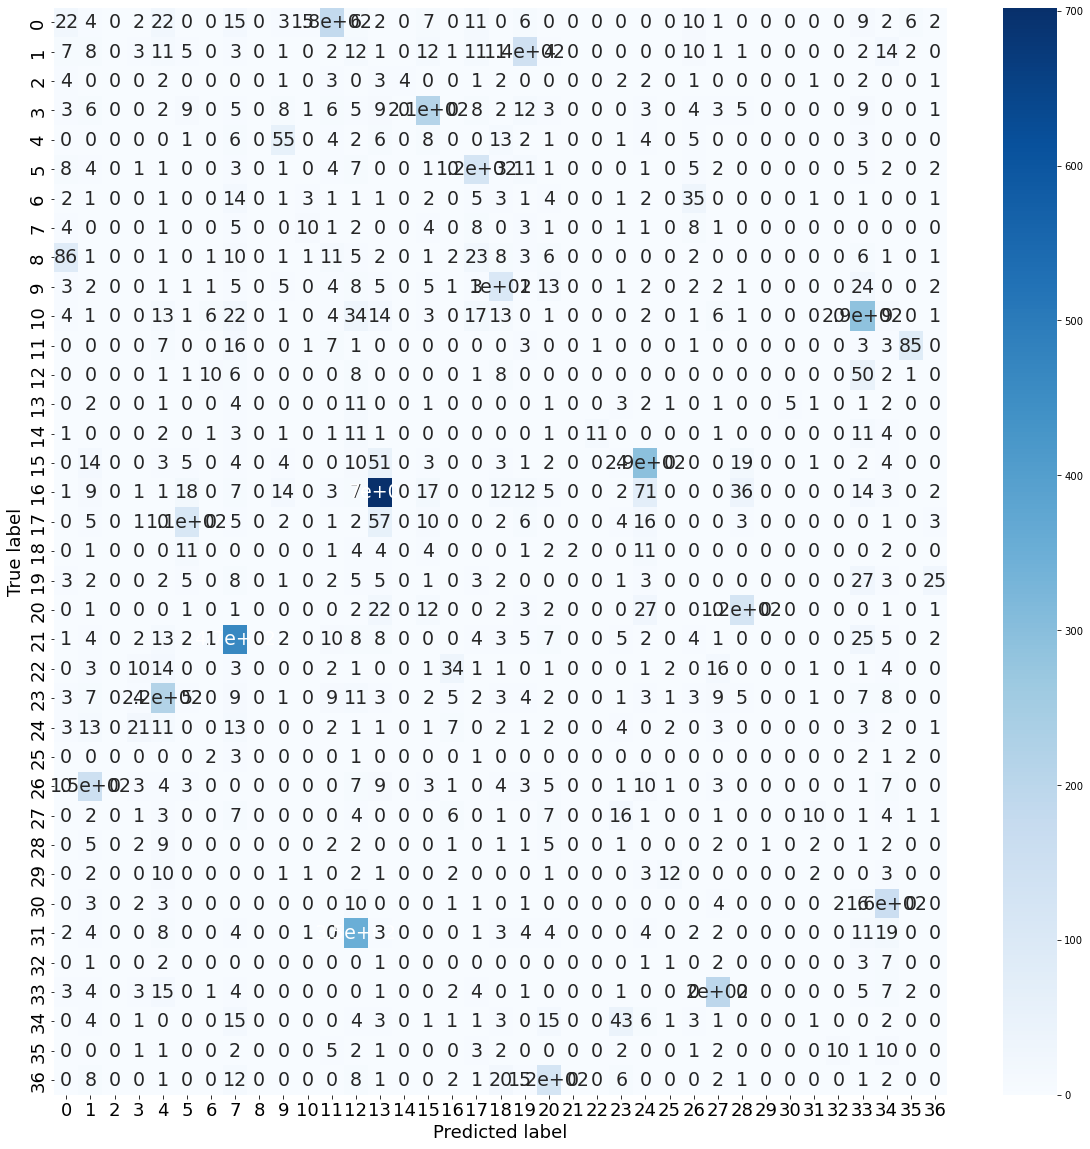

In [37]:
y_true = predicted_df['GWA ID']
y_pred = pred_gwa_id

cm = confusion_matrix(y_true, y_pred)
conf_matrix = pd.DataFrame(cm)

# plot size setting
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 19}, cmap="Blues")
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('confusion.pdf', bbox_inches='tight')
plt.show()

In [38]:
conf_matrix

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,22,4,0,2,22,0,0,15,0,3,...,1,0,0,0,0,0,9,2,6,2
1,7,8,0,3,11,5,0,3,0,1,...,1,1,0,0,0,0,2,14,2,0
2,4,0,0,0,2,0,0,0,0,1,...,0,0,0,0,1,0,2,0,0,1
3,3,6,0,0,2,9,0,5,0,8,...,3,5,0,0,0,0,9,0,0,1
4,0,0,0,0,0,1,0,6,0,55,...,0,0,0,0,0,0,3,0,0,0
5,8,4,0,1,1,0,0,3,0,1,...,2,0,0,0,0,0,5,2,0,2
6,2,1,0,0,1,0,0,14,0,1,...,0,0,0,0,1,0,1,0,0,1
7,4,0,0,0,1,0,0,5,0,0,...,1,0,0,0,0,0,0,0,0,0
8,86,1,0,0,1,0,1,10,0,1,...,0,0,0,0,0,0,6,1,0,1
9,3,2,0,0,1,1,1,5,0,5,...,2,1,0,0,0,0,24,0,0,2
